Tim Day
862016623
CS105

Two Questions we are seeking to answer:

1) Which 5 stocks on the nasdaq 100 are predicted to be among the best buys during trading hours based on historic data.

2) Which 10 stocks of the nasdaq top 100 are the best performers at this very moment, based on live data, and how do they compare with best predicted buys.

In [ ]:
## Config ## Start #

# Update live/historic data
updateLive = False
updateHistoric = False

# Normalize stock data features
norm = True

# Neural Net Solvers: sgd, adam
solver = 'sgd'

# Historic Dates
start_date = '2020-02-27'
end_date = '2020-03-07'

# print verbose scraper output
print_scraper_output = False

## Config ## End #

In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output

In [3]:
## Get Historic Data Func ## START #

def get_historic_to_csv(stocks_list, start, end, col, verbose=0):

    # create temp dataframe
    df_temp = pd.DataFrame(columns=stocks_list)
    
    for metric in col:
        for ticker in stocks_list:
            df_temp[ticker] = yf.download(ticker, start, end)[metric]
            if not verbose:
                clear_output()
        
        #df_temp = df_temp.T
        df_temp.to_csv('./data_files/' + metric +'_historic.csv')

## Get Historic Data Func ## END #

In [4]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import time

## Get Live Data Func ## START #

def get_live_to_csv():
    # get url
    top_100_live = requests.get('https://www.stockmonitor.com/nasdaq-stocks/')

    # parse with BS4
    soup = BeautifulSoup(top_100_live.content,"html.parser")

    # pull data for columns
    tmp_lst=[]
    for row in soup.table.find_all('tr')[1:]:
        r_td = row.find_all('td')
        f=[]
        for obj in r_td:
            temp = obj.text.replace("\n","")
            f.append(temp.replace(" ",""))
        tmp_lst.append(f)
    
    # create dataframe
    df = pd.DataFrame(data = tmp_lst, columns = ["change","symbol","name","price","volume","high","low"])
    
    # clean data
    df['high'] = df['high'].str.replace(',','')
    df['high'] = df['high'].str.replace('\r','')
    df['low'] = df['low'].str.replace(',','')
    df['low'] = df['low'].str.replace('\r','')
    df['price'] = df['price'].str.replace(',','')
    df['price'] = df['price'].str.replace('\r','')
    df['volume'] = df['volume'].str.replace('\r', '')
    df['volume'] = df['volume'].str.replace(',', '')
    df['name'] = df['name'].str.replace('\r', '')
    df['change'] = df['change'].str[1:-1].astype(float)

    # specify types
    df['high'] = df['high'].astype('float')
    df['low'] = df['low'].astype('float')
    df['price'] = df['price'].astype('float')
    df['volume'] = df['volume'].astype('int')
    
    # list of current top 100 stocks
    top_100 = []
    top_100 = list(df['symbol'])

    # set symbol as index
    df.set_index('symbol',inplace=True)

    # save to csv
    df.to_csv('./data_files/top_100_live.csv')
    
    # save stock list to file
    with open('./data_files/stock_list_current.txt', 'w+') as f:
        for listitem in top_100:
            f.write('%s\n' % listitem)
    
    return top_100

## Get Live Data Func ## END #

In [5]:
## Main Function Calls ## START #

stock_list = []
# live top 100 nasdaq -> top_100_live.csv
if updateLive == True:
  stock_list = get_live_to_csv()

# get stock list if get live stocks not previuosly run
if stock_list == []:
    with open('./data_files/stock_list_current.txt', 'r') as f:
        for line in f:
            currentPlace = line[:-1]
            stock_list.append(currentPlace)

# historic dates -> yfinance_nasdaq_100.csv
col_data = ['Open','Adj Close','Volume','High','Low']
if updateHistoric == True:
  get_historic_to_csv(stock_list, start_date, end_date, col_data, print_scraper_output)

## Function Calls ## END #

In [6]:
## Data Combine ## Start #

# historic data, drop tickers that have empty values i.e. insufficient history data
df_Open = (pd.read_csv('./data_files/Open_historic.csv', index_col=0).T).dropna().astype(float)
df_Close = (pd.read_csv('./data_files/Adj Close_historic.csv', index_col=0).T).dropna().astype(float)
df_Volume = (pd.read_csv('./data_files/Volume_historic.csv', index_col=0).T).dropna().astype(int)
df_High = (pd.read_csv('./data_files/High_historic.csv', index_col=0).T).dropna().astype(float)
df_Low = (pd.read_csv('./data_files/Low_historic.csv', index_col=0).T).dropna().astype(float)

# update stock list for possible dropped tickers
stock_list = df_Volume.index.tolist()

# verify rows equal, if not error
if not (df_Open.shape[0] == df_Close.shape[0] == df_Volume.shape[0] ==  df_High.shape[0] == df_Low.shape[0]):
    print('Row number mismatch among features...')
    print('df_Open:',df_Open.shape[0])
    print('df_Close:',df_Close.shape[0])
    print('df_Volume:',df_Volume.shape[0])
    print('df_High:',df_High.shape[0])
    print('df_Low:',df_Low.shape[0])
    exit()

# live data
df_live = pd.read_csv('./data_files/top_100_live.csv', index_col=0)

# calculate percent change historic
df_diff = df_Open.subtract(df_Close)
df_pChange = df_diff.divide(df_Open)

# find cuurent top five positive movers of the day from live data
df_top10_live = (df_live.sort_values(by=['change']))[-10:]
top10_list = list(df_top10_live.index)

## Data Combine ## End #

In [7]:
## Normalize ## Start #

if norm == True:
    df_Vol_normed=(df_Volume.T-df_Volume.T.mean())/df_Volume.T.std()
    df_Open_normed=(df_Open.T-df_Open.T.mean())/df_Open.T.std()
    df_Close_normed=(df_Close.T-df_Close.T.mean())/df_Close.T.std()
    df_High_normed=(df_High.T-df_High.T.mean())/df_High.T.std()
    df_Low_normed=(df_Low.T-df_Low.T.mean())/df_Low.T.std()
    df_diff_normed=(df_diff.T-df_diff.T.mean())/df_diff.T.std()
    df_pChange_normed=(df_pChange.T-df_pChange.T.mean())/df_pChange.T.std()
    
    # norm test stocks based on train norms
    #df_live['price'] = (df_live['price']-df_Close.T.mean())/df_Close.T.std()
    #df_live['volume'] = (df_live['volume']-df_Volume.T.mean())/df_Volume.T.std()
    #df_live['high'] = (df_live['high']-df_High.T.mean())/df_High.T.std()
    #df_live['low'] = (df_live['low']-df_Low.T.mean())/df_Low.T.std()

    # norm all live stocks together
    #df_live=df_live.drop(columns=['name'])
    #df_live=(df_live-df_live.mean())/df_live.std()
    
else:
    df_Vol_normed=df_Volume.T
    df_Open_normed=df_Open.T
    df_Close_normed=df_Close.T
    df_High_normed=df_High.T
    df_Low_normed=df_Low.T
    df_diff_normed=df_diff.T
    df_pChange_normed=df_pChange.T

## Normalize ## End #

In [8]:
from sklearn.linear_model import LinearRegression

#####
## Linear Regression ### Start #
#####

# create df for resultant predictions
pred_each_stock_LR = pd.DataFrame(columns=['symbol','GreatestMover_pred'])

# get prediction for each stock
for symb in stock_list:
    
    # side stack to build traning set for symbol
    X_train = pd.concat([df_Close_normed[symb], df_Vol_normed[symb], 
                         df_High_normed[symb], df_Low_normed[symb]], axis=1)
    
    # rename columns
    X_train.columns = [['close','volume','high','low']]

    # labels
    y_train = df_pChange_normed[symb]

    # generate and fit model to historic data
    model = LinearRegression()
    model.fit(X=X_train, y=y_train)

    # create test case
    X_test = df_live.loc[symb][['price','volume','high','low']]
    X_test = np.reshape(X_test.to_numpy().tolist() , (1,-1))
    
    # predict on live data
    pred = model.predict(X=X_test)
    
    # save prediction for symbol
    pred_each_stock_LR = pred_each_stock_LR.append({'symbol': symb,'GreatestMover_pred': pred }, ignore_index=True)

# set symbol as index
pred_each_stock_LR = pred_each_stock_LR.set_index('symbol')

# clean brackets from predicted values
pred_each_stock_LR['GreatestMover_pred'] = pred_each_stock_LR['GreatestMover_pred'].astype(float)

# save predictions to csv
pred_each_stock_LR.to_csv('./data_files/LR_predictions.csv')

# find best five of the day, predicted
best_five_buys_LR = pred_each_stock_LR.nlargest(5, ['GreatestMover_pred']).head()

# make numbers easier to interpret/compare
best_five_buys_LR = (best_five_buys_LR-best_five_buys_LR.mean())/best_five_buys_LR.std()

#####
## Linear Regression ### End #
#####

In [9]:
from sklearn.neural_network import MLPRegressor
from sklearn import preprocessing

#####
## Neural-Net Regressor ### Start #
#####

# create df for resultant predictions
pred_each_stock_NN = pd.DataFrame(columns=['symbol','GreatestMover_pred'])

# get prediction for each stock
for symb in stock_list:
    
    # side stack to build traning set for symbol
    X_train = pd.concat([df_Close_normed[symb], df_Vol_normed[symb], 
                         df_High_normed[symb], df_Low_normed[symb]], axis=1)
    
    # rename columns
    X_train.columns = [['close','volume','high','low']]

    # labels
    y_train = df_pChange_normed[symb]
    lab_enc = preprocessing.LabelEncoder()
    training_scores_encoded = lab_enc.fit_transform(y_train)

    # generate and fit model to historic data
    model = MLPRegressor(solver=solver, max_iter=10000, activation='relu',
                           random_state=1, learning_rate_init=0.01,
                           batch_size=X_train.shape[0])
    model.fit(X_train, training_scores_encoded)

    # create test case
    X_test = df_live.loc[symb][['price','volume','high','low']]
    X_test = np.reshape(X_test.to_numpy().tolist() , (1,-1))
    
    # predict on live data
    pred = model.predict(X=X_test)
    
    # save prediction for symbol
    pred_each_stock_NN  = pred_each_stock_NN.append({'symbol': symb,'GreatestMover_pred': pred }, ignore_index=True)


# set symbol as index
pred_each_stock_NN = pred_each_stock_NN.set_index('symbol')

# clean brackets from predicted values
pred_each_stock_NN['GreatestMover_pred'] = pred_each_stock_NN['GreatestMover_pred'].astype(float)

# save predictions to csv
pred_each_stock_NN.to_csv('./data_files/NN_predictions.csv')

# find best five of the day, predicted
best_five_buys_NN = pred_each_stock_NN.nlargest(5, ['GreatestMover_pred']).head()

# make numbers easier to interpret/compare
best_five_buys_NN = (best_five_buys_NN-best_five_buys_NN.mean())/best_five_buys_NN.std()

#####
## Neural-Net Regressor ### End #
#####

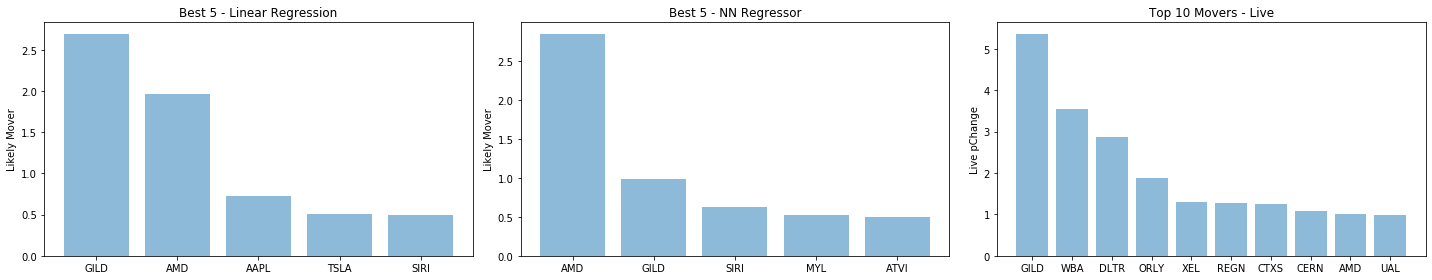

In [10]:
## Visualize ## Start #

## best_five_buys_LR #

# determine min val and add  all to to make chart more easily interpretable
min_val = np.absolute(best_five_buys_LR['GreatestMover_pred'].min())
best_five_buys_LR = best_five_buys_LR + min_val + .5

# bar vars
num = np.arange(len(best_five_buys_LR.index.tolist()))
y_vals = best_five_buys_LR['GreatestMover_pred']
names = best_five_buys_LR.index

plt.subplot(1,3,1)
# bar chart
plt.bar(num, y_vals, align='center', alpha=0.5)
plt.xticks(num, names)
plt.ylabel('Likely Mover')
plt.title('Best 5 - Linear Regression')

## best_five_buys_NN #

# determine min val and add  all to to make chart more easily interpretable
min_val = np.absolute(best_five_buys_NN['GreatestMover_pred'].min())
best_five_buys_NN = best_five_buys_NN + min_val + .5

plt.subplot(1,3,2)
# bar vars
num = np.arange(len(best_five_buys_NN.index.tolist()))
y_vals = best_five_buys_NN['GreatestMover_pred']
names = best_five_buys_NN.index

# bar chart
plt.bar(num, y_vals, align='center', alpha=0.5)
plt.xticks(num, names)
plt.ylabel('Likely Mover')
plt.title('Best 5 - NN Regressor')

## #df_top10_live #

# sort by percent change to match ordering of other charts
df_top10_live.sort_values(by=['change'], inplace=True, ascending=False)

plt.subplot(1,3,3)
# bar vars
num = np.arange(len(df_top10_live.index.tolist()))
y_vals = df_top10_live['change']
names = df_top10_live.index

# bar chart
plt.bar(num, y_vals, align='center', alpha=0.5)
plt.xticks(num, names)
plt.ylabel('Live pChange')
plt.title('Top 10 Movers - Live')

fig = plt.gcf()
fig.set_size_inches(20,4)

plt.tight_layout()
plt.show()

## Visualize ## End #

In [11]:
## Interpret ## Start #

algos_agree_on = set(best_five_buys_LR.index) & set(best_five_buys_NN.index)
print('The machine learning algos agreed on {}: {}'.format(len(algos_agree_on) ,algos_agree_on))

in_top_10_live = set(df_top10_live.index) & algos_agree_on  
print('Among the Live top 10, both algos agree on {}: {}'.format(len(in_top_10_live),in_top_10_live))

## Interpret ## End #

The machine learning algos agreed on 3: {'SIRI', 'AMD', 'GILD'}
Among the Live top 10, both algos agree on 2: {'AMD', 'GILD'}


If you ran this program at market open and purchased GILD and AMD based on these predictions, you would have made over 5% on GILD and about 1.5% on AMD by the bell close.